In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [2]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [3]:
df = pd.read_csv('owid-covid-data.csv') # having First.csv zipped file.

In [4]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [5]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [6]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [7]:
df = df.fillna(df.median())

In [8]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [9]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [10]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [11]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [12]:
#df['month'] = df['date'].dt.month

In [13]:
# Parametrages sequences 
nb_seq=7
n_out=7
nb_col=5

In [14]:
start_date = '2020-06-15'
end_date = '2020-08-01'
start_date2 = '2020-08-02'
end_date2 = '2020-08-15'

In [15]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [16]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [17]:
df.sort_values(by=['location'], inplace=True)

In [18]:
X_train_1 = df.loc[mask1].sort_index(axis = 0) 
X_train_1.shape

(48, 7)

In [19]:
X_train_1.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23033,42.0,8734.0,212.0,0.0,36910558.0,2020-06-15,Morocco
23034,104.0,8838.0,212.0,0.0,36910558.0,2020-06-16,Morocco
23035,83.0,8921.0,212.0,0.0,36910558.0,2020-06-17,Morocco
23036,76.0,8997.0,213.0,1.0,36910558.0,2020-06-18,Morocco
23037,77.0,9074.0,213.0,0.0,36910558.0,2020-06-19,Morocco


In [20]:
X_train_1.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23076,609.0,20887.0,316.0,3.0,36910558.0,2020-07-28,Morocco
23077,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
23078,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
23079,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
23080,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco


In [21]:
#Date to add test set 
data_add_test = X_train_1[X_train_1.location =='Morocco'].tail(nb_seq)

In [22]:
X_train_1.shape

(48, 7)

In [23]:
X_train_1.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23033,42.0,8734.0,212.0,0.0,36910558.0,2020-06-15,Morocco
23034,104.0,8838.0,212.0,0.0,36910558.0,2020-06-16,Morocco
23035,83.0,8921.0,212.0,0.0,36910558.0,2020-06-17,Morocco
23036,76.0,8997.0,213.0,1.0,36910558.0,2020-06-18,Morocco
23037,77.0,9074.0,213.0,0.0,36910558.0,2020-06-19,Morocco
23038,539.0,9613.0,213.0,0.0,36910558.0,2020-06-20,Morocco
23039,188.0,9801.0,213.0,0.0,36910558.0,2020-06-21,Morocco
23040,176.0,9977.0,214.0,1.0,36910558.0,2020-06-22,Morocco
23041,195.0,10172.0,214.0,0.0,36910558.0,2020-06-23,Morocco
23042,92.0,10264.0,214.0,0.0,36910558.0,2020-06-24,Morocco


In [24]:
X_train_1.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23071,220.0,17962.0,285.0,5.0,36910558.0,2020-07-23,Morocco
23072,302.0,18264.0,292.0,7.0,36910558.0,2020-07-24,Morocco
23073,570.0,18834.0,299.0,7.0,36910558.0,2020-07-25,Morocco
23074,811.0,19645.0,305.0,6.0,36910558.0,2020-07-26,Morocco
23075,633.0,20278.0,313.0,8.0,36910558.0,2020-07-27,Morocco
23076,609.0,20887.0,316.0,3.0,36910558.0,2020-07-28,Morocco
23077,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
23078,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
23079,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
23080,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco


In [25]:
X_test_1 = df.loc[mask2].sort_index(axis = 0) 

X_test_1.shape

(14, 7)

In [26]:
X_test_1

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23081,693.0,25015.0,367.0,14.0,36910558.0,2020-08-02,Morocco
23082,522.0,25537.0,382.0,15.0,36910558.0,2020-08-03,Morocco
23083,659.0,26196.0,401.0,19.0,36910558.0,2020-08-04,Morocco
23084,1021.0,27217.0,417.0,16.0,36910558.0,2020-08-05,Morocco
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco


In [27]:
#raise SystemExit("Stop right there!")

In [28]:
X_test_1

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23081,693.0,25015.0,367.0,14.0,36910558.0,2020-08-02,Morocco
23082,522.0,25537.0,382.0,15.0,36910558.0,2020-08-03,Morocco
23083,659.0,26196.0,401.0,19.0,36910558.0,2020-08-04,Morocco
23084,1021.0,27217.0,417.0,16.0,36910558.0,2020-08-05,Morocco
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco


In [29]:
X_test_1 = pd.concat([pd.DataFrame(data_add_test),X_test_1], ignore_index=True)
X_test_1 = X_test_1.sort_index(axis = 0)

In [30]:
X_test_1

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,811.0,19645.0,305.0,6.0,36910558.0,2020-07-26,Morocco
1,633.0,20278.0,313.0,8.0,36910558.0,2020-07-27,Morocco
2,609.0,20887.0,316.0,3.0,36910558.0,2020-07-28,Morocco
3,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
4,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
5,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
6,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco
7,693.0,25015.0,367.0,14.0,36910558.0,2020-08-02,Morocco
8,522.0,25537.0,382.0,15.0,36910558.0,2020-08-03,Morocco
9,659.0,26196.0,401.0,19.0,36910558.0,2020-08-04,Morocco


In [31]:
X_test_1['timestamp'] = pd.to_datetime(X_test_1['date'], infer_datetime_format=True)
X_test_1.set_index('timestamp', inplace=True)

X_train_1['timestamp'] = pd.to_datetime(X_train_1['date'], infer_datetime_format=True)
X_train_1.set_index('timestamp', inplace=True)

In [32]:
X_train_1=X_train_1[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test_1=X_test_1[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test_1=X_test_1[['new_cases']]

Y_train_1 =X_train_1[['new_cases']]

In [33]:
days=X_test_1[nb_seq:].index
days=days.sort_values()

In [34]:
#days=days[nb_seq:]

In [35]:
print(X_train_1.shape)
print(Y_train_1.shape)
print(X_test_1.shape)
print(Y_test_1.shape)

(48, 5)
(48, 1)
(21, 5)
(21, 1)


In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [37]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [38]:

# ensure all data is float
X_train_1 = X_train_1.astype('float32')
# ensure all data is float
X_test_1 = X_test_1.astype('float32')
# ensure all data is float
Y_test_1 = Y_test_1.astype('float32')
# ensure all data is float
Y_train_1 = Y_train_1.astype('float32')

# normalize features

X_train_1= scaler.fit_transform(X_train_1)
X_test_1= scaler.fit_transform(X_test_1)
Y_train_1= scaler2.fit_transform(Y_train_1)
Y_test_1= scaler2.fit_transform(Y_test_1)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train_1 = series_to_supervised(X_train_1, nb_seq, n_out)
X_test_1 = series_to_supervised(X_test_1, nb_seq, n_out)
print(X_train_1)
print(X_train_1.shape)
print(X_test_1.shape)
Y_train_1 = series_to_supervised(Y_train_1, nb_seq, n_out)
Y_test_1 = series_to_supervised(Y_test_1, nb_seq, n_out)
print(Y_train_1.shape)
print(Y_test_1.shape)


    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var1(t-6)  \
7    0.039511   0.000000   0.000000   0.000000        0.0   0.097836   
8    0.097836   0.006672   0.000000   0.000000        0.0   0.078081   
9    0.078081   0.011996   0.000000   0.000000        0.0   0.071496   
10   0.071496   0.016872   0.007092   0.083333        0.0   0.072436   
11   0.072436   0.021812   0.007092   0.000000        0.0   0.507056   
12   0.507056   0.056390   0.007092   0.000000        0.0   0.176858   
13   0.176858   0.068450   0.007092   0.000000        0.0   0.165569   
14   0.165569   0.079741   0.014184   0.083333        0.0   0.183443   
15   0.183443   0.092250   0.014184   0.000000        0.0   0.086548   
16   0.086548   0.098152   0.014184   0.000000        0.0   0.604892   
17   0.604892   0.139402   0.028369   0.166667        0.0   0.405456   
18   0.405456   0.167052   0.035461   0.083333        0.0   0.277516   
19   0.277516   0.185976   0.042553   0.083333        0.0   0.22

In [39]:
print(X_test_1)

    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var1(t-6)  \
7    0.311311   0.000000   0.000000       0.12        0.0   0.133133   
8    0.133133   0.032302   0.026144       0.20        0.0   0.109109   
9    0.109109   0.063380   0.035948       0.00        0.0   0.000000   
10   0.000000   0.088896   0.071895       0.32        0.0   0.326326   
11   0.326326   0.131047   0.094771       0.16        0.0   0.546547   
12   0.546547   0.184425   0.133987       0.36        0.0   0.563564   
13   0.563564   0.238671   0.156863       0.16        0.0   0.193193   
14   0.193193   0.274036   0.202614       0.44        0.0   0.022022   

    var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  ...  var1(t+5)  var2(t+5)  \
7    0.032302   0.026144       0.20        0.0  ...   0.644645   0.510257   
8    0.063380   0.035948       0.00        0.0  ...   0.518519   0.562207   
9    0.088896   0.071895       0.32        0.0  ...   0.845846   0.630843   
10   0.131047   0.094771       0.16        

In [40]:
#col_y_need_train = df.filter(regex=("d.*"))

In [41]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train_1

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
7,0.039511,0.000000,0.000000,0.000000,0.0,0.097836,0.006672,0.000000,0.000000,0.0,...,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0
8,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,...,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0
9,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,...,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0
10,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,...,0.223895,0.228124,0.092199,0.333333,0.0,0.228598,0.243713,0.113475,0.250000,0.0
11,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,...,0.228598,0.243713,0.113475,0.250000,0.0,0.096896,0.250321,0.113475,0.000000,0.0
12,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,...,0.096896,0.250321,0.113475,0.000000,0.0,0.313264,0.271683,0.120567,0.083333,0.0
13,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,...,0.313264,0.271683,0.120567,0.083333,0.0,0.300094,0.292148,0.127660,0.083333,0.0
14,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,...,0.300094,0.292148,0.127660,0.083333,0.0,0.502352,0.326405,0.141844,0.166667,0.0
15,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,...,0.502352,0.326405,0.141844,0.166667,0.0,0.369708,0.351617,0.163121,0.250000,0.0
16,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,...,0.369708,0.351617,0.163121,0.250000,0.0,0.107244,0.358930,0.163121,0.000000,0.0


In [42]:
Y_train_1.head(5)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.039511,0.097836,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539
8,0.097836,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628
9,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628,0.223895
10,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628,0.223895,0.228598
11,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628,0.223895,0.228598,0.096896


In [43]:
#raise SystemExit("Stop right there!")

In [44]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [45]:
col_x_need_train =X_train_1.filter(regex=regex_find,axis=1).head(1)

In [46]:
col_x_need_train

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.039511,0.0,0.0,0.0,0.0,0.097836,0.006672,0.0,0.0,0.0,...,0.507056,0.05639,0.007092,0.0,0.0,0.176858,0.06845,0.007092,0.0,0.0


In [47]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train_1.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539


In [48]:
#raise SystemExit("Stop right there!")

In [49]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [50]:
#col_x_need_train

In [51]:
# drop columns we don't want to predict
Y_train_1 = Y_train_1.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test_1=Y_test_1.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
print(Y_train_1.shape)
print(Y_test_1.shape)


(35, 7)
(8, 7)


In [52]:
Y_train_1.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539
8,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628
9,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628,0.223895
10,0.604892,0.405456,0.277516,0.229539,0.164628,0.223895,0.228598
11,0.405456,0.277516,0.229539,0.164628,0.223895,0.228598,0.096896


In [53]:
# drop columns we don't want to predict
X_train_1 = X_train_1.filter(regex=regex_find,axis=1)
X_test_1=X_test_1.filter(regex=regex_find,axis=1)
print(X_train_1.shape)
print(X_test_1.shape)
X_train_1


(35, 35)
(8, 35)


,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.039511,0.000000,0.000000,0.000000,0.0,0.097836,0.006672,0.000000,0.000000,0.0,...,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0
8,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,...,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0
9,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,...,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0
10,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,...,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0
11,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,...,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0
12,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,...,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0
13,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,...,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0
14,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,...,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0
15,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,...,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0
16,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,...,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0


In [54]:
X_test_1

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.311311,0.000000,0.000000,0.12,0.0,0.133133,0.032302,0.026144,0.20,0.0,...,0.546547,0.184425,0.133987,0.36,0.0,0.563564,0.238671,0.156863,0.16,0.0
8,0.133133,0.032302,0.026144,0.20,0.0,0.109109,0.063380,0.035948,0.00,0.0,...,0.563564,0.238671,0.156863,0.16,0.0,0.193193,0.274036,0.202614,0.44,0.0
9,0.109109,0.063380,0.035948,0.00,0.0,0.000000,0.088896,0.071895,0.32,0.0,...,0.193193,0.274036,0.202614,0.44,0.0,0.022022,0.300674,0.251634,0.48,0.0
10,0.000000,0.088896,0.071895,0.32,0.0,0.326326,0.131047,0.094771,0.16,0.0,...,0.022022,0.300674,0.251634,0.48,0.0,0.159159,0.334303,0.313726,0.64,0.0
11,0.326326,0.131047,0.094771,0.16,0.0,0.546547,0.184425,0.133987,0.36,0.0,...,0.159159,0.334303,0.313726,0.64,0.0,0.521522,0.386405,0.366013,0.52,0.0
12,0.546547,0.184425,0.133987,0.36,0.0,0.563564,0.238671,0.156863,0.16,0.0,...,0.521522,0.386405,0.366013,0.52,0.0,0.783784,0.451878,0.424837,0.60,0.0
13,0.563564,0.238671,0.156863,0.16,0.0,0.193193,0.274036,0.202614,0.44,0.0,...,0.783784,0.451878,0.424837,0.60,0.0,0.644645,0.510257,0.470588,0.44,0.0
14,0.193193,0.274036,0.202614,0.44,0.0,0.022022,0.300674,0.251634,0.48,0.0,...,0.644645,0.510257,0.470588,0.44,0.0,0.518519,0.562207,0.509804,0.36,0.0


In [55]:
print(X_test_1.shape)

(8, 35)


In [56]:
nb_col=5

In [57]:
X_test_1.head(1)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.311311,0.0,0.0,0.12,0.0,0.133133,0.032302,0.026144,0.2,0.0,...,0.546547,0.184425,0.133987,0.36,0.0,0.563564,0.238671,0.156863,0.16,0.0


In [58]:
Y_test_1

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.193193,0.022022,0.159159,0.521522,0.783784,0.644645,0.518519
8,0.022022,0.159159,0.521522,0.783784,0.644645,0.518519,0.845846
9,0.159159,0.521522,0.783784,0.644645,0.518519,0.845846,0.730731
10,0.521522,0.783784,0.644645,0.518519,0.845846,0.730731,0.326326
11,0.783784,0.644645,0.518519,0.845846,0.730731,0.326326,0.632633
12,0.644645,0.518519,0.845846,0.730731,0.326326,0.632633,1.000000
13,0.518519,0.845846,0.730731,0.326326,0.632633,1.000000,0.741742
14,0.845846,0.730731,0.326326,0.632633,1.000000,0.741742,0.806807


In [59]:

X_train=X_train_1.values
X_test=X_test_1.values

Y_train=Y_train_1.values
Y_test=Y_test_1.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(8, 1, 35) (8, 7) (35, 1, 35) (35, 7)


In [60]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(8, 1, 35) (8, 7) (35, 1, 35) (35, 7)


In [61]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [62]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [63]:
Y_test[0]

array([0.1931932 , 0.02202201, 0.15915912, 0.5215215 , 0.78378373,
       0.6446447 , 0.5185185 ], dtype=float32)

(35, 1, 35)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 1, 75)             25200     
_________________________________________________________________
gru_13 (GRU)                 (None, 25)                7650      
_________________________________________________________________
dropout_6 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 182       
Total params: 33,032
Trainable params: 33,032
Non-trainable params: 0
_________________________________________________________________


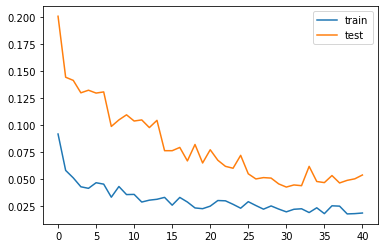

(35, 7)
(35, 7)
(35, 7)
score_train: [119.943] 126.0, 126.7, 128.6, 123.2, 110.2, 103.5, 119.1
(8, 1, 35)
score_test: [230.993] 287.3, 244.0, 268.6, 76.3, 289.0, 202.8, 169.8


In [199]:
from tensorflow.keras.callbacks import EarlyStopping

print(X_train.shape)
model = keras.Sequential()  
model.add(GRU(75, activation='tanh',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(GRU(50, activation='tanh',return_sequences=True))
model.add(GRU(25, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(n_out))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, Y_train, epochs=200,batch_size=1, validation_data=(X_test[[0,7]], Y_test[[0,7]]), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0)
model.summary()
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

pred_train = model.predict(X_train)
print(pred_train.shape)
pred_train = pred_train.reshape(-1,n_out)

print(Y_train.shape)
print(pred_train.shape)
score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
summarize_scores('score_train', score_train, scores_train) 

print(X_test.shape)
prediction = model.predict(X_test) 
prediction = prediction.reshape(-1, n_out)


score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7]]) ,scaler2.inverse_transform(prediction[[0,7]]))
summarize_scores('score_test', score_test, scores_test) 


In [200]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7]])
yhat.shape 

(2, 7)

In [201]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [202]:
#yhat

In [203]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)
#print(inv_y)

In [204]:
days

DatetimeIndex(['2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [205]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:14]
test_res['real']=y_test_true.flatten()[0:14]
test_res.set_index(days,inplace=True)

In [206]:
test_res

,Prediction,real
timestamp,,
2020-08-02,814.082458,693.0
2020-08-03,828.824341,522.0
2020-08-04,857.606384,659.0
2020-08-05,916.198853,1021.0
2020-08-06,918.996277,1283.0
2020-08-07,960.602478,1144.0
2020-08-08,976.782715,1018.0
2020-08-09,957.195618,1345.0
2020-08-10,1071.952026,1230.0


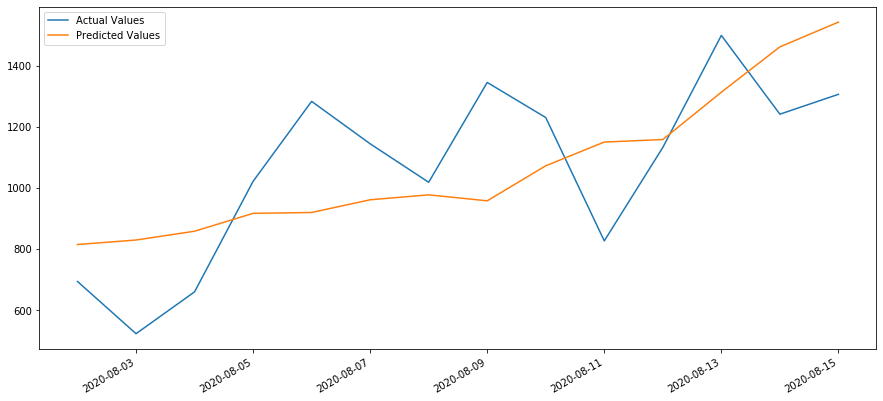

In [207]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [208]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 53357.78
RMSE: 230.99
MAE: 204.17
R Squared: 0.32
Max Error: 387.8


In [209]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(35, 7)

In [210]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(35, 7)

In [211]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [212]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [213]:
y_train_pred[0]

array([743.9515, 739.0786, 754.1782, 818.8164, 775.0884, 758.0768,
       771.4311], dtype=float32)

In [214]:
#For plot 
filter_indices = [0,5,11,17,23]
y_train_pred = y_train_pred [filter_indices ]

In [215]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [216]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(35, 1, 35)

In [217]:
date_train.head(7)

23033   2020-06-15
23034   2020-06-16
23035   2020-06-17
23036   2020-06-18
23037   2020-06-19
23038   2020-06-20
23039   2020-06-21
Name: date, dtype: datetime64[ns]

In [218]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

41

In [219]:
date_train = date_train.values.flatten()

In [220]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [221]:
Y_train_pred.shape

(35,)

In [222]:
Y_train_real.shape

(35,)

In [223]:
date_train.shape

(48,)

In [224]:
date_train[nb_seq:].shape

(41,)

In [225]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-6

In [226]:
Y_train_real[:-suite_size].shape

(6,)

In [227]:
date_train[nb_seq:].shape

(41,)

In [228]:
Y_train_pred[:-suite_size].shape

(6,)

In [229]:
Y_train_real[:-suite_size].shape

(6,)

In [230]:
date_trainX = date_train[nb_seq:]

In [231]:
date_trainX[0:Y_train_pred.shape[0]].shape

(35,)

In [232]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [233]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [234]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [235]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-06-22,665.403564,743.951477
2020-06-23,683.259644,739.078613
2020-06-24,586.460938,754.178223
2020-06-25,1104.286987,818.816406
2020-06-26,905.050781,775.088379
2020-06-27,777.238892,758.076782
2020-06-28,729.309509,771.431091
2020-06-29,777.238892,729.934875
2020-06-30,729.309509,738.913818


In [236]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-07-17,690.777954,665.380920
2020-07-18,679.500488,641.788574
2020-07-19,651.306702,661.104675
2020-07-20,651.306702,713.507874
2020-07-21,655.065857,741.865295
2020-07-22,652.246521,792.936768
2020-07-23,783.817505,805.197144
2020-07-24,771.600159,809.604004
2020-07-25,707.694214,838.348694


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

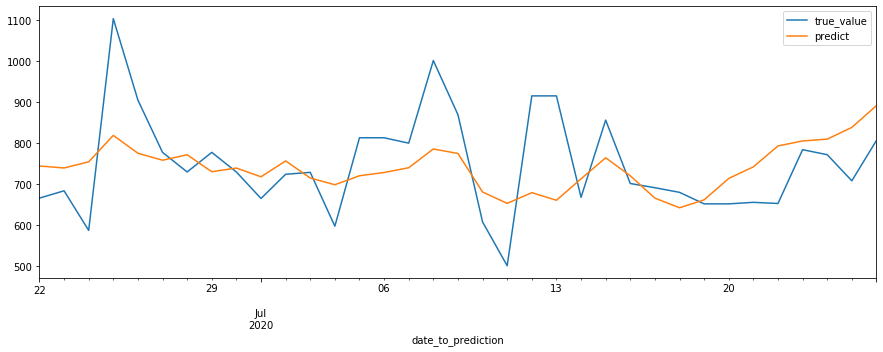

In [237]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [238]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 14386.30
RMSE 119.94
MAE 93.97
R2 0.59
maxError 343.82


In [239]:
test_res.to_csv('GRU_res7.csv')
prediction_train.to_csv('GRU_train7.csv')